In [1]:
import os
import sys
basepath = '/' + os.path.join('Users', 'zach', 'Git', 'Masterarbeit', 'Project')
sys.path.append(basepath)

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Enable full width output for numpy (https://stackoverflow.com/questions/43514106/python-terminal-output-width)
np.set_printoptions(suppress=True, linewidth=250, threshold=250)

from src.ml.training import load_model
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers, Shift, Edge
from src.d.utils import u
from data.fortran_test.utils import get_predictions, plot_vofs, create_plot
from src.ml.building import custom_loss

In [3]:
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers, Shift, Edge
import subprocess
import re

# Suppress tensorflow logging
import logging
import os
from itertools import product as itpd
from multiprocessing import Process

# import threading
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

st_sz = [9, 9]

filename = f'./data_{st_sz[0]}x{st_sz[1]}_eqk_neg_ell_smr_shift1_g.feather'
file = pd.read_feather(filename)
print(f'Shape:\t{file.shape}')

Shape:	(999710, 82)


In [4]:
parameters = {'stencil_size': st_sz, 'angle': False}
data_pipeline = Pipeline([
    ('transform', TransformData(parameters=parameters, reshape=False)),
    ('findgradient', FindGradient(parameters=parameters)),
    ('findangle', FindAngle(parameters=parameters)),
    #('shift', Shift(parameters=parameters)),  # Output: [labels, data, angle_matrix]
    #('rotate', Rotate(parameters=parameters)),  # Output: [labels, data, angle_matrix]    
    ('edge', Edge(parameters=parameters)),  # Output: [labels, data, angle_matrix]    
])
[lab_e, feat_e, ang_e] = data_pipeline.fit_transform(file)

In [5]:
parameters = {'stencil_size': st_sz, 'angle': False}
data_pipeline = Pipeline([
    ('transform', TransformData(parameters=parameters, reshape=False)),
    ('findgradient', FindGradient(parameters=parameters)),
    ('findangle', FindAngle(parameters=parameters)),
    #('shift', Shift(parameters=parameters)),  # Output: [labels, data, angle_matrix]
    #('rotate', Rotate(parameters=parameters)),  # Output: [labels, data, angle_matrix]    
    #('edge', Edge(parameters=parameters)),  # Output: [labels, data, angle_matrix]    
])
[lab, feat, ang2] = data_pipeline.fit_transform(file)

In [13]:
# Get random values
np.random.seed(2) 
indices = np.random.permutation(feat.shape[0])

features_e_x = feat_e[indices, :int(feat_e.shape[1]/2)]
features_e_y = feat_e[indices, int(feat_e.shape[1]/2):]
labels_e = lab_e[indices]#*0.075/128
features = feat[indices, :]
features = np.reshape(features, (features.shape[0],st_sz[0],st_sz[1]))[:, 1:-1, 1:-1]

labels = lab[indices]#*0.075/128

In [14]:
#model = '_mlp_1000_200-150-120_7x7_rot_flp_cut_dshift1_shift1_nbi_6'
#predictions = get_predictions(features, basepath=basepath, filename=model)#*faktor  # vector_last*faktor # 

CVOFLS: [ 0.42  -0.2   -0.515 -0.305 -0.003  0.448 -0.013 -0.063 -0.255  0.12 ]



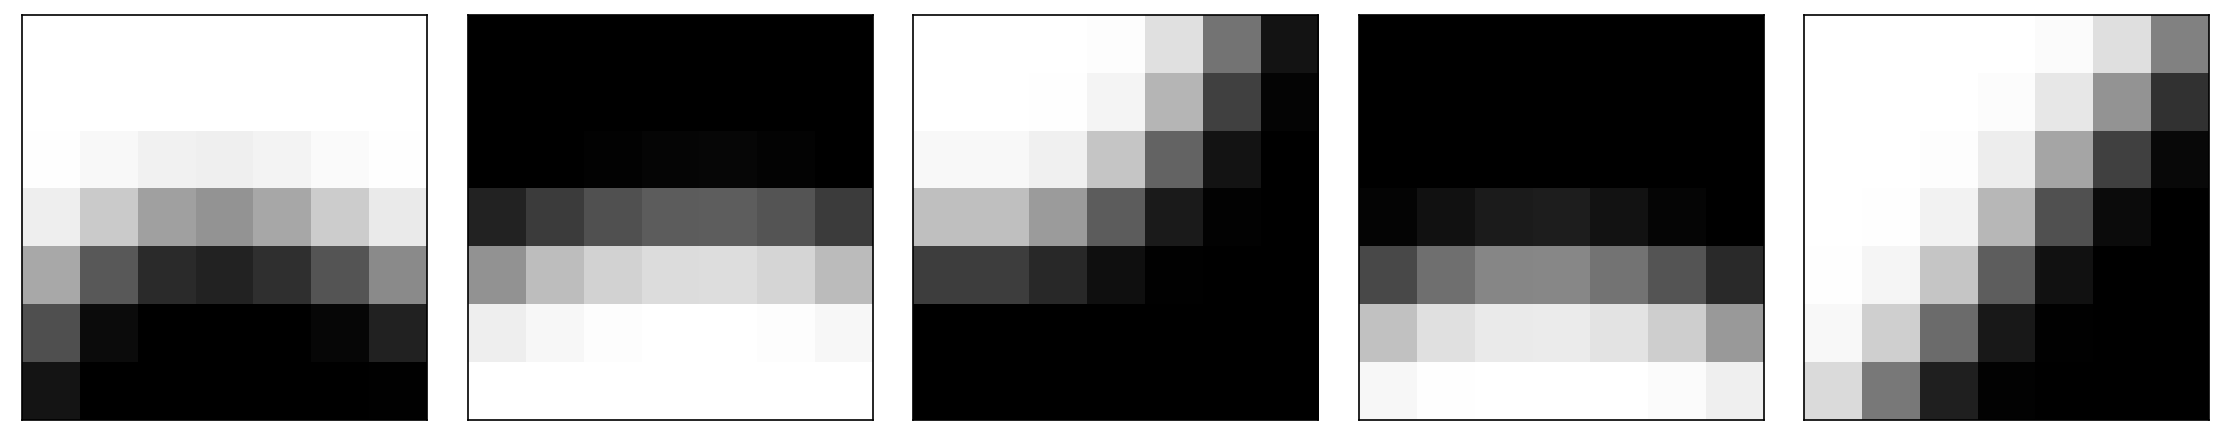

In [15]:
#print(f'Predictions: {np.round(predictions[:10], 3)}')
print(f'CVOFLS: {np.round(labels[:10], 3)}')
    
n_plots = 5
plot_vofs(np.reshape(features, (features.shape[0],st_sz[0]-2,st_sz[1]-2)), n_plots, per_row=5)

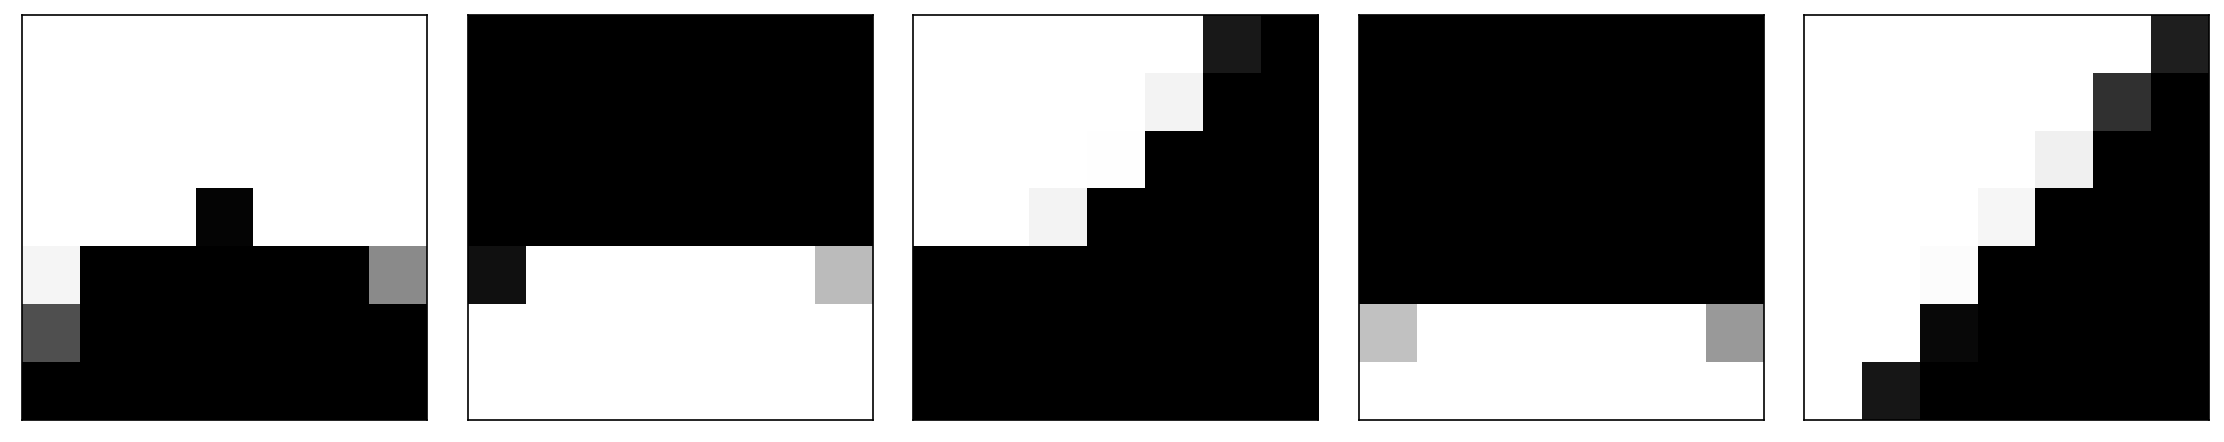

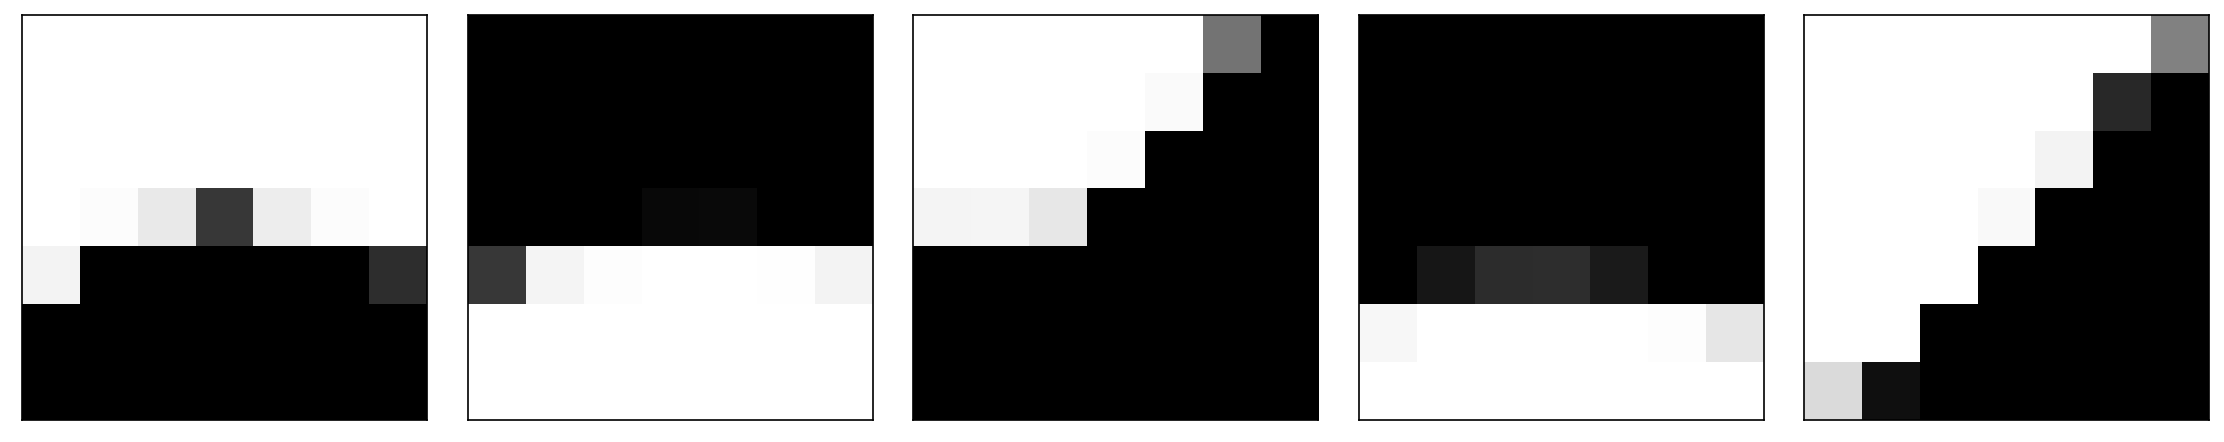

In [16]:
n_plots = 5
plot_vofs(np.reshape(features_e_x, (features.shape[0],st_sz[0]-2,st_sz[1]-2)), n_plots, per_row=5)
plot_vofs(np.reshape(features_e_y, (features.shape[0],st_sz[0]-2,st_sz[1]-2)), n_plots, per_row=5)

In [35]:
stencil = np.array(
    [[0.0, 0.0, 0.0, 0.0, 0.62109375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ],
     [0.0, 0.0, 0.0, 0.0, 0.34960938, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ],
     [0.0, 0.0, 0.0, 0.0, 0.06152344, 0.97363281, 1.0, 1.0, 1.0, 1.0, 1.0, ],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.67480469, 1.0, 1.0, 1.0, 1.0, 1.0, ],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.26953125, 1.0, 1.0, 1.0, 1.0, 1.0, ],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.00195312, 0.80859375, 1.0, 1.0, 1.0, 1.0, ],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.30566406, 1.0, 1.0, 1.0, 1.0, ],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00097656, 0.74414062, 1.0, 1.0, 1.0, ],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15527344, 0.96777344, 1.0, 1.0, ],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4375, 1.0, 1.0, ],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00292969, 0.67871094, 1.0, ]])

In [83]:
gauss = 1
st_sz_tmp = stencil.shape

cut_st = int((st_sz_tmp[0]-7)/2)
output_array = np.reshape(stencil[cut_st:-cut_st, cut_st:-cut_st], (1, stencil.shape[0]-4, stencil.shape[1]-4))

for interpolate in [0.5, 1, 2]:
    sm_it = (int(np.ceil(interpolate)) if interpolate else 1)
    vof_array = stencil

    # Define smearing kernel
    if gauss:
        kernel = [[1, 2, 1], [2, 4, 2], [1, 2, 1]]  # Gauß
    else:
        kernel = [[0, 1, 0], [1, 4, 1], [0, 1, 0]]  # FNB

    # Make dictionary for unsmoothed and smoothed stencils
    vof_array_dict = {0: vof_array.copy()}

    # Get random factor between 0 and interpolate. The resulting vof_array will be a linear combination of vof_array smoothed floor(a) and ceil(a) times, where the factor defining the point inbetween both that should be interpolated is a-floor(a). If interpolate = 0 smoothing should be applied once.
    a = (interpolate*1 if interpolate else 1)
    for i in range(int(np.ceil(a))):
        # Attach array filled with nan to dictionary
        vof_array_dict[i+1] = vof_array.copy()
        vof_array_dict[i+1][:] = np.nan
        # Fill array with smoothed values of last array (or unsmoothed array)
        for column in range(1+i, st_sz_tmp[0]-1-i):
            for row in range(1+i, st_sz_tmp[1]-1-i):
                # Calculate smeared vof field: sum(weights * vof_array_slice)/sum(weights)
                vof_array_dict[i+1][column, row] = np.sum(np.multiply(
                    kernel,
                    vof_array_dict[i][column-1:column+2, row-1:row+2]
                ))/np.sum(kernel)

    if interpolate:
        # Cut edges of arrays. vof_smear_array_1 is stencil with smoothing kernel applied floor(a) times, vof_smear_array_2 with it applied ceil(a) times.
        vof_smear_array_1 = vof_array_dict[int(np.floor(a))][sm_it:st_sz_tmp[0]-sm_it, sm_it:st_sz_tmp[1]-sm_it]
        vof_smear_array_2 = vof_array_dict[int(np.ceil(a))][sm_it:st_sz_tmp[0]-sm_it, sm_it:st_sz_tmp[1]-sm_it]
        # Lineary interpolate between the two arrays
        vof_array = vof_smear_array_1 + (a-np.floor(a))*(vof_smear_array_2-vof_smear_array_1)
    else:
        # Cut edges of vof_array
        vof_array = vof_array_dict[sm_it][sm_it:st_sz_tmp[0]-sm_it, sm_it:st_sz_tmp[1]-sm_it]

    # Cut if too big
    if vof_array.shape[0] > output_array.shape[1]:
        cut_by = int((vof_array.shape[0] - output_array.shape[1])/2)
        vof_array = vof_array[cut_by:-cut_by, cut_by:-cut_by]
    
    output_array = np.concatenate((output_array, np.reshape(vof_array, (1, vof_array.shape[0], vof_array.shape[1]))), axis=0)

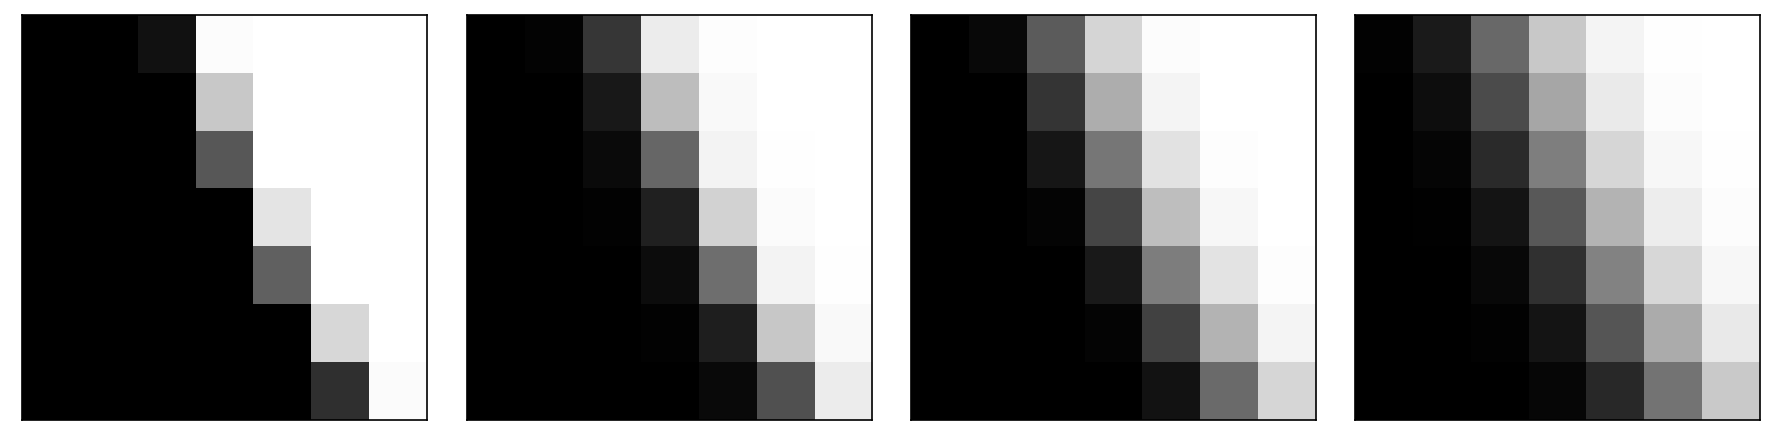

In [84]:
n_plots = 4
plot_vofs(output_array, n_plots, per_row=4)